In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

# some other library are imported along with the code
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.despine(left=True, bottom=True)

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

<Figure size 432x288 with 0 Axes>

In [2]:
# load the data we saved from the first notebook part 1 
loans_2007_2019 = pd.read_csv('loans_2007_2019_cleaned.csv')

# view 1th rows
display(loans_2007_2019.head(1))

print('The total number of rows and columns in our cleaned 2007 to 2019 loan data is: ',loans_2007_2019.shape)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,loan_status
0,3600.0,36 months,6.03,109.57,A,2.0,RENT,45000.0,Not Verified,credit_card,MA,11.52,0.0,0.0,11.0,3433.0,11.8,22.0,1


The total number of rows and columns in our cleaned 2007 to 2019 loan data is:  (30931, 19)


In [3]:
# read investment data made from part 1.
investment = pd.read_csv('investment.csv')
# add loan grade column
investment['loan_grade']=['A','B','C','D','E','F','G'] # since I saved the data as index=False, so i need to add it back.
# view the table
investment

,charged_off_rate,interest_rate,loan_grade
0,0.059693,0.073353,A
1,0.119069,0.110216,B
2,0.167180,0.135536,C
3,0.212207,0.157234,D
4,0.253674,0.177173,E
5,0.306452,0.197530,F
6,0.317610,0.213953,G


Note: From part 1, we have found the proportion of the loans between different grade are not the same, and I also mentioned that 'Charged-Off' rate does NOT mean the when the loans are charged off, investor will loss all the principal and interest, because loan payment schedul is a mortgage-like arrangement and a loan maybe charged off during the loan term. This can explain why the charged-off rate is even higher than interest rate except for A loans.

From first row, we can see if an investor put 25 dollar per loan and invest in 1000 loan, and ONLY choose A loans to invest, the average expected return is 7.1%, but if he/she lose all the money for the loans that are charged-off, the net return is: 0.071004-0.059498 = 1.5%. We can also calculate as following:

In [4]:
# calculate the worst case for expected return 
((0.073353-0.059693)*25*1000)/(25*1000)

0.013659999999999999

In [5]:
def my_metric(model, X_test, y_test):
    
    # getting predicted values
    y_predict = model.predict(X_test)
    
    # False positives
    fp_filter = (y_predict == 1) & (y_test == 0)
    fp = len(y_predict[fp_filter])
    
    # True positives.
    tp_filter = (y_predict == 1) & (y_test == 1)
    tp = len(y_predict[tp_filter])
    
    # False negatives.
    fn_filter = (y_predict == 0) & (y_test == 1)
    fn = len(y_predict[fn_filter])
    
    # True negatives
    tn_filter = (y_predict == 0) & (y_test == 0)
    tn = len(y_predict[tn_filter])
    
    # Rates
    tpr = tp  / (tp + fn)
    fpr = fp  / (fp + tn)
    precision = tp/(tp+fp)
    
    print('Confusion matrix: \n', confusion_matrix(y_test, y_predict))
    # print(classification_report(y_test,y_predict)) # we don't need this
    print('The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn): ', tpr)
    print('The False Positive Rate (1-specification)is fpr = fp/(fp+tn): ', fpr)
    print('The Precision (tp/(tp+fp)) is: ', precision)
    print('\n')

In [6]:
def precision_recall_curves(model, X_test, y_test):
    
    # plot Precision Recall Curve
    plt.figure(figsize=(8,6))
    
    # predict probabilities
    probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    
    # get predicted class value
    y_predict = model.predict(X_test)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    
    # plot no skill
    plt.plot([0, 1], [0.8, 0.8], linestyle='--') 
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, color='darkorange', marker='.')
    plt.xlabel('Recall (sensitivity, or True Positive Rate)')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    
    return plt.show()

In [7]:
def investment_return_with_my_model(model, X_test, y_test):
    
    # get predicted class value
    y_predict = model.predict(X_test)
    # reshape
    y_predict = y_predict.reshape((y_predict.shape[0], 1))
    # put it into a dataframe
    y_predict = pd.DataFrame(y_predict, index=range(0,len(y_predict)), columns=['loan_status_predicted'])
    
    # Join X_test and y_test using 'join' since they have the same index
    loans_test = X_test.join(y_test)
    
    # Then join the test dataframe with y_predict; Since it is different index, I created a 'Join' column and then use 'merge'
    loans_test['Join']=list(range(0,len(y_predict)))
    y_predict['Join']=list(range(0,len(y_predict)))
    # Merge test data with predicted data
    loans_test_with_predict = pd.merge(loans_test, y_predict, on='Join')
    
    # filter the rows that are predicted as 1
    predict_should_invest = loans_test_with_predict[loans_test_with_predict['loan_status_predicted']==1]
    
    # Among the loans predicted as 1, filter the rows thar are actually as 1
    actual_should_invest = predict_should_invest[predict_should_invest['loan_status']==1]
    
    # calculate the mistake rate, this is the same as fpr
    mistake_rate = (predict_should_invest.shape[0]-actual_should_invest.shape[0])/predict_should_invest.shape[0]
    
    # add a new column, indicating for each loan we invest 25 dollars
    predict_should_invest['invest_amount'] = 25
    
    # add a new column, calculating interest earned from this loan by multiplying interest rate per loan with the amount invested per loan
    predict_should_invest['interest_earned']=(predict_should_invest['int_rate']/100)*predict_should_invest['invest_amount']
    
    # sum the interest earned for all the loans we invested
    total_interest = predict_should_invest['interest_earned'].sum()
    
    # calculate our investment return
    investment_return = total_interest/(25*len(predict_should_invest))
    print('The investment return with this model is: ', '{:.2%}'.format(investment_return))
    
    # calculate the return for the worse case, meaning if we lost all the money from the loans that are charged-off
    #(including full amount of principal and interest, which is less likely), how much return we will get.
    investment_return_with_maxlosss = (total_interest-(mistake_rate*(25*len(predict_should_invest))))/(25*len(predict_should_invest))
    print('The investment return with this model for the worse case is: ', '{:.2%}'.format(investment_return_with_maxlosss))
    print('\n')
#     print(predict_should_invest.head())

In [8]:
display(loans_2007_2019.head(1))


,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,loan_status
0,3600.0,36 months,6.03,109.57,A,2.0,RENT,45000.0,Not Verified,credit_card,MA,11.52,0.0,0.0,11.0,3433.0,11.8,22.0,1


In [9]:
# select object columns
object_columns = loans_2007_2019.select_dtypes(include=["object"])

object_columns.head(1)


,term,grade,home_ownership,verification_status,purpose,addr_state
0,36 months,A,RENT,Not Verified,credit_card,MA


In [10]:
# Encode object columns to integer values and return a Dataframe containing the dummy columns.
dummy_df = pd.get_dummies(loans_2007_2019[object_columns.columns], drop_first=True)

# combine dummy column dataframe with original dataframe as column
loans_2007_2019 = pd.concat([loans_2007_2019, dummy_df], axis=1)

# drop original object columns
loans_2007_2019 = loans_2007_2019.drop(object_columns.columns, axis=1)

# review the result with 3 rows
display(loans_2007_2019.head(1))

print('The number of rows and columns in our machine learning model is : ', loans_2007_2019.shape)

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,loan_status,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,3600.0,6.03,109.57,2.0,45000.0,11.52,0.0,0.0,11.0,3433.0,11.8,22.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The number of rows and columns in our machine learning model is :  (30931, 88)


In [11]:
features = loans_2007_2019.drop('loan_status', axis=1)

target = loans_2007_2019['loan_status']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [12]:
# create our model
lr_mymodel_default = LogisticRegression().fit(X_train, y_train)
# use my function
my_metric(lr_mymodel_default, X_test, y_test)
investment_return_with_my_model(lr_mymodel_default, X_test, y_test)

Confusion matrix: 
 [[   4 1296]
 [   4 7976]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.9994987468671679
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.9969230769230769
The Precision (tp/(tp+fp)) is:  0.8602243313201036


The investment return with this model is:  11.98%
The investment return with this model for the worse case is:  -2.00%




In [13]:
# creat model, set model parameter with balanced
lr_mymodel_balanced = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
# use my function
my_metric(lr_mymodel_balanced, X_test, y_test)
investment_return_with_my_model(lr_mymodel_balanced, X_test, y_test)

Confusion matrix: 
 [[ 805  495]
 [3520 4460]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.5588972431077694
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.38076923076923075
The Precision (tp/(tp+fp)) is:  0.900100908173562


The investment return with this model is:  10.51%
The investment return with this model for the worse case is:  0.52%




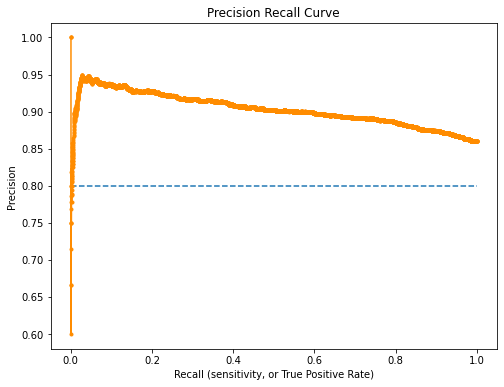

In [14]:
precision_recall_curves(lr_mymodel_balanced, X_test, y_test)

In [15]:
# create model, with balanced 
rf_balanced = RandomForestClassifier(class_weight="balanced", random_state=1).fit(X_train, y_train)
# use my function
my_metric(rf_balanced, X_test, y_test)
investment_return_with_my_model(rf_balanced, X_test, y_test)

Confusion matrix: 
 [[   6 1294]
 [   7 7973]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.9991228070175439
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.9953846153846154
The Precision (tp/(tp+fp)) is:  0.8603647350814719


The investment return with this model is:  11.97%
The investment return with this model for the worse case is:  -2.00%




In [16]:

# set model parameter with different penalty
for i in [6, 7, 8, 9, 10]:   
    # creat our model
    penalty = {0: i, 1: 1} 
    lrf_mymodel_penalty = LogisticRegression(class_weight=penalty).fit(X_train, y_train)
    # use my function
    my_metric(lrf_mymodel_penalty, X_test, y_test)  
    investment_return_with_my_model(lrf_mymodel_penalty, X_test, y_test)

Confusion matrix: 
 [[ 795  505]
 [3436 4544]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.569423558897243
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.38846153846153847
The Precision (tp/(tp+fp)) is:  0.8999801940978411


The investment return with this model is:  10.54%
The investment return with this model for the worse case is:  0.54%


Confusion matrix: 
 [[1004  296]
 [4645 3335]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.41791979949874686
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.2276923076923077
The Precision (tp/(tp+fp)) is:  0.9184797576425228


The investment return with this model is:  9.55%
The investment return with this model for the worse case is:  1.39%


Confusion matrix: 
 [[1040  260]
 [5104 2876]]
The True Positive Rate (Recall/Sensitivity)is tpr = tp/(tp+fn):  0.36040100250626567
The False Positive Rate (1-specification)is fpr = fp/(fp+tn):  0.2
The Precision (tp/(tp+fp)) is

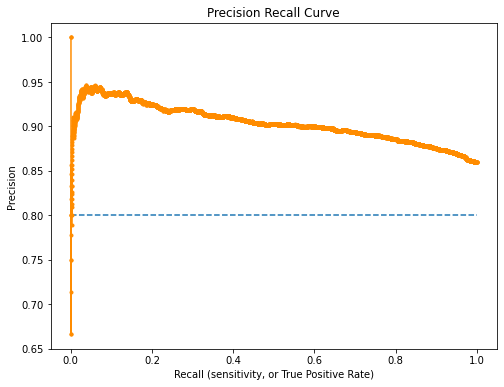

In [17]:
#Curve for the above model
precision_recall_curves(lrf_mymodel_penalty, X_test, y_test)